In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.feature_selection import mutual_info_regression

In [3]:
import seaborn as sns

In [4]:
# load consolidated unemployment rate data exported by mx4.ipynb
# Cities with incomplete data (not every month represented) were removed
# removed cities: Dehradun, Gangtok, and Srinagar
# Data is monthly from January 2018 to July 2022
df = pd.read_csv('air_quality_macrox/unemployment_IN/city_unemployment_rates.csv')
df.head()

,rate_Agartala,rate_Agra,rate_Aizwal,rate_Amritsar,rate_Asansol,rate_Aurangabad,rate_Bareilly,rate_Belgaum,rate_Bengaluru,rate_Bhilai,...,rate_Patna,rate_Prayagraj,rate_Puducherry,rate_Pune,rate_Shillong,rate_Solapur,rate_Thiruvananthapuram,rate_Varanasi,rate_Vijayawada,rate_Visakhapatnam
0,31.11,4.03,5.01,6.69,8.63,3.47,4.03,1.79,1.79,6.72,...,4.07,4.03,4.44,3.47,10.86,3.47,6.88,4.03,5.79,5.79
1,30.23,3.93,5.87,9.64,8.83,3.83,3.93,3.32,3.32,2.61,...,7.05,3.93,2.02,3.83,7.92,3.83,8.27,3.93,3.97,3.97
2,15.19,3.14,6.00,9.01,7.92,3.36,3.14,3.97,3.97,3.20,...,10.21,3.14,3.94,3.36,6.72,3.36,9.80,3.14,4.22,4.22
3,13.55,5.56,5.57,7.16,6.24,4.88,5.56,2.28,2.28,2.06,...,7.97,5.56,1.65,4.88,4.04,4.88,6.67,5.56,3.65,3.65
4,23.68,5.21,5.14,7.26,7.37,3.74,5.21,1.64,1.64,4.34,...,5.07,5.21,2.27,3.74,10.54,3.74,5.67,5.21,4.01,4.01


In [5]:
# function to help make list of all 51 city names
def pull_out_city_name_after_(city):
    i = city.find('_')
    return city[i+1:]

In [6]:
# make list of cities using columns of the dataframe
city_list = [pull_out_city_name_after_(city) for city in list(df.columns)]

In [7]:
city_series = pd.Series(city_list, name='city')

In [8]:
date = pd.date_range(start='1/31/2018', end='7/31/2018', freq='M', name='date')

In [9]:
# load data for NO2, SO2, PM2.5 and CO (January 2018 to July 2022) that has had
# January 2018 to November 2020 Openweathermap.org data backfilled and output as csv's
# using jupyter notebook code from mx3.ipynb
df_no2 = pd.read_csv('no2_api_backfill.csv')
df_so2 = pd.read_csv('so2_api_backfill.csv')
df_pm = pd.read_csv('pm_api_backfill.csv')
df_co = pd.read_csv('co_api_backfill.csv')

In [10]:
# resolve different name in economic data csv file
df_no2 = df_no2.rename(columns={'NO2_Vijaywada': 'NO2_Vijayawada'})
df_so2 = df_so2.rename(columns={'SO2_Vijaywada': 'SO2_Vijayawada'})
df_pm = df_pm.rename(columns={'PM2_5_Vijaywada': 'PM2_5_Vijayawada'})
df_co = df_co.rename(columns={'CO_Vijaywada': 'CO_Vijayawada'})

In [11]:
# pull out dates of pollutants as series
pollutant_dates = pd.to_datetime(df_no2['date'])

In [12]:
# define thresholds for pollutants
threshold_no2 = 40
threshold_so2 = 40
threshold_pm = 30
threshold_co = 1000

mi_city_arr = np.zeros((51,8))

for ii, city in enumerate(city_list):
    # create X (feature matrix)
    X = np.hstack((df_no2.filter(like=city, axis=1).to_numpy(),
                   df_so2.filter(like=city, axis=1).to_numpy(),
                   df_pm.filter(like= city, axis=1).to_numpy(),
                   df_co.filter(like= city, axis=1).to_numpy()))
    # apply thresholds to each column of feature matrix X
    X[:,0][X[:,0] < threshold_no2] = 0.0
    X[:,1][X[:,1] < threshold_so2] = 0.0
    X[:,2][X[:,2] < threshold_pm] = 0.0
    X[:,3][X[:,3] < threshold_co] = 0.0
    # scale all elements to units of corresponding thresholds
    # therefore divide each column by its threshold
    # note: zero elements should remain zero
    X[:,0] = X[:,0] / threshold_no2
    X[:,1] = X[:,1] / threshold_so2
    X[:,2] = X[:,2] / threshold_pm
    X[:,3] = X[:,3] / threshold_co
    
    
    
    # Make X into dataframe so that pandas groupby can be used
    df_X = pd.DataFrame(X)
    # insert the date so that it can be a key used for Grouper
    df_X.insert(0,'date',pollutant_dates)
    # for each month, sum up the over threshold days scaled by
    # the thresholds themselves. If the threshold is 80 and an entry
    # is 120, that days entry will be 1.5
    df_X = df_X.groupby(pd.Grouper(key='date', freq='1M')).sum()
    # create new feature matrix X with monthly data points
    X = df_X.to_numpy()
    assert X.shape == (55,4), f'for {city} matrix shape: {X.shape} not equal to (55,4)'
    # Add new features: the one month change in the pollutant concentration
    # This will result in one less row for the overall feature data matrix
    X_delta = X[1:,:] - X[:54,:]
    # combine new difference features with original features
    X_e = np.hstack((X[1:,:], X_delta))
    assert X_e.shape == (54,8), f'for {city} matrix shape: {X_e.shape} not equal to (54,8)'
    # create response, y - monthly unemployment data
    y = df.filter(like=city, axis=1).to_numpy().flatten()
    # remove 1st data point of y to be compatible with X_e containing the difference features
    y_e = y[1:]
    
    # Investigate mutual information between the response, unemployment rate
    # and each feature. The reported mutual information for each city will be scaled
    # by the feature with the maximum value--the highest mutual information value will be one
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html
    mi = mutual_info_regression(X_e, y_e, random_state=37)
    
    if np.max(mi) != 0.0:
        mi_scaled = mi / np.max(mi)
    else:
        mi_scaled = mi
    mi_city_arr[ii] = mi_scaled

In [13]:
mi_city_arr.shape

(51, 8)

In [14]:
df_mi = pd.DataFrame(mi_city_arr,
                     columns=['NO2','SO2','PM2_5','CO','delta_NO2','delta_SO2','delta_PM2_5','delta_CO'])
df_mi.insert(loc=0, column='city', value=city_series)
df_mi.head()

,city,NO2,SO2,PM2_5,CO,delta_NO2,delta_SO2,delta_PM2_5,delta_CO
0,Agartala,0.000000,0.0,1.0,0.346672,0.0,0.000000,0.088454,0.165304
1,Agra,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
2,Aizwal,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.353297,0.000000
3,Amritsar,0.480647,0.0,0.0,0.000000,1.0,0.000000,0.481382,0.000000
4,Asansol,0.125915,0.0,1.0,0.796477,0.0,0.492561,0.516533,0.000000


In [15]:
df_mi.set_index('city', inplace=True)

In [16]:
df_mi.head()

,NO2,SO2,PM2_5,CO,delta_NO2,delta_SO2,delta_PM2_5,delta_CO
city,,,,,,,,
Agartala,0.000000,0.0,1.0,0.346672,0.0,0.000000,0.088454,0.165304
Agra,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000
Aizwal,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.353297,0.000000
Amritsar,0.480647,0.0,0.0,0.000000,1.0,0.000000,0.481382,0.000000
Asansol,0.125915,0.0,1.0,0.796477,0.0,0.492561,0.516533,0.000000


<AxesSubplot:ylabel='city'>

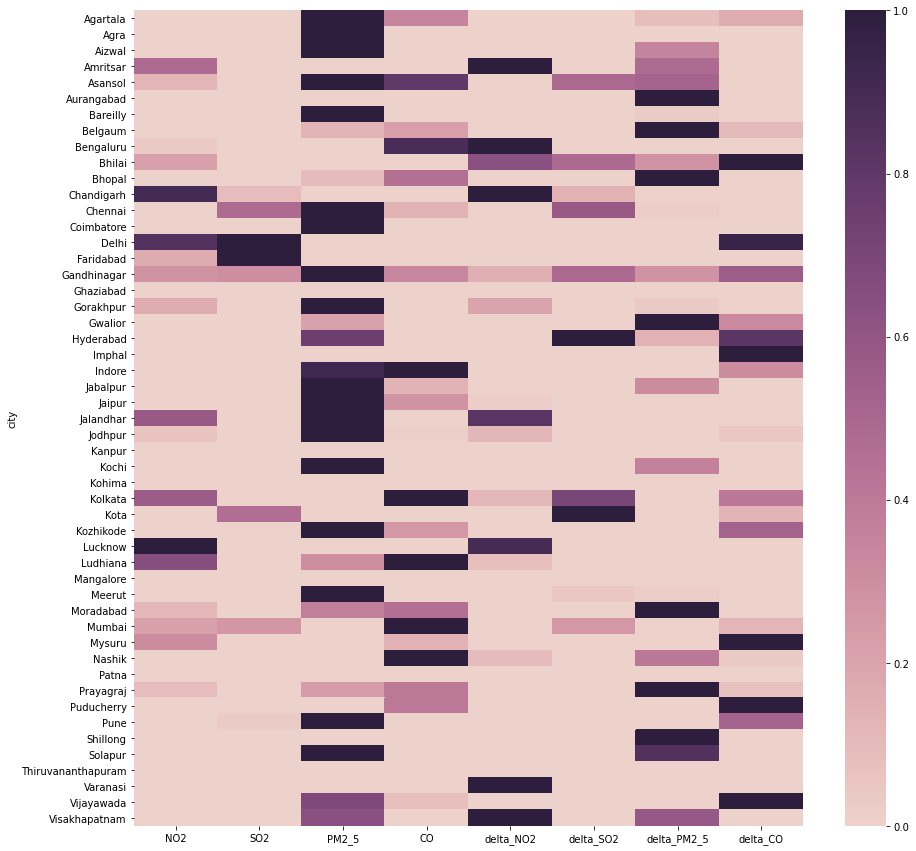

In [17]:
plt.subplots(figsize=(15,15))
sns.heatmap(df_mi, cmap=sns.cubehelix_palette(as_cmap=True))

In [18]:
# Load random forest importance data for the 51 cities
df_rf = pd.read_csv('random_forest_importance.csv')

In [19]:
df_rf.set_index('city', inplace=True)

<AxesSubplot:ylabel='city'>

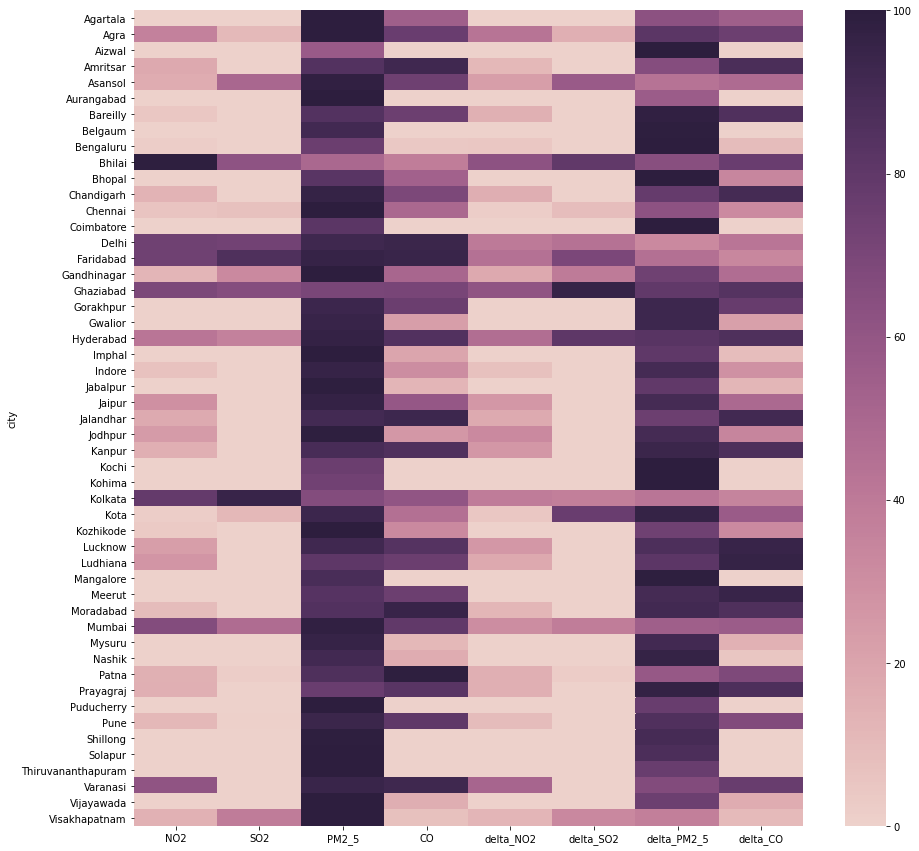

In [20]:
plt.subplots(figsize=(15,15))
sns.heatmap(df_rf, cmap=sns.cubehelix_palette(as_cmap=True))

In [23]:
np.count_nonzero(df_rf.to_numpy(), axis=0)

array([30, 15, 51, 40, 29, 15, 51, 40], dtype=int64)

In [24]:
import plotly.express as px

In [27]:
fig = px.imshow(df_mi, aspect='auto')

In [28]:
fig.show()

In [34]:
fig = px.imshow(mi_city_arr, aspect='auto')

In [35]:
fig.show()

In [39]:
# Check different threshold fractions and their effect on mutual information
mi_animation_arr = np.zeros((40,51,8))
ii = 0
for threshold_fraction in np.arange(0.2,0.6,0.01):
    # define thresholds for pollutants
    threshold_no2 = 80 * threshold_fraction
    threshold_so2 = 80 * threshold_fraction
    threshold_pm = 60 * threshold_fraction
    threshold_co = 2000 * threshold_fraction

    mi_city_arr = np.zeros((51,8))

    for jj, city in enumerate(city_list):
        # create X (feature matrix)
        X = np.hstack((df_no2.filter(like=city, axis=1).to_numpy(),
                       df_so2.filter(like=city, axis=1).to_numpy(),
                       df_pm.filter(like= city, axis=1).to_numpy(),
                       df_co.filter(like= city, axis=1).to_numpy()))
        # apply thresholds to each column of feature matrix X
        X[:,0][X[:,0] < threshold_no2] = 0.0
        X[:,1][X[:,1] < threshold_so2] = 0.0
        X[:,2][X[:,2] < threshold_pm] = 0.0
        X[:,3][X[:,3] < threshold_co] = 0.0
        # scale all elements to units of corresponding thresholds
        # therefore divide each column by its threshold
        # note: zero elements should remain zero
        X[:,0] = X[:,0] / threshold_no2
        X[:,1] = X[:,1] / threshold_so2
        X[:,2] = X[:,2] / threshold_pm
        X[:,3] = X[:,3] / threshold_co



        # Make X into dataframe so that pandas groupby can be used
        df_X = pd.DataFrame(X)
        # insert the date so that it can be a key used for Grouper
        df_X.insert(0,'date',pollutant_dates)
        # for each month, sum up the over threshold days scaled by
        # the thresholds themselves. If the threshold is 80 and an entry
        # is 120, that days entry will be 1.5
        df_X = df_X.groupby(pd.Grouper(key='date', freq='1M')).sum()
        # create new feature matrix X with monthly data points
        X = df_X.to_numpy()
        assert X.shape == (55,4), f'for {city} matrix shape: {X.shape} not equal to (55,4)'
        # Add new features: the one month change in the pollutant concentration
        # This will result in one less row for the overall feature data matrix
        X_delta = X[1:,:] - X[:54,:]
        # combine new difference features with original features
        X_e = np.hstack((X[1:,:], X_delta))
        assert X_e.shape == (54,8), f'for {city} matrix shape: {X_e.shape} not equal to (54,8)'
        # create response, y - monthly unemployment data
        y = df.filter(like=city, axis=1).to_numpy().flatten()
        # remove 1st data point of y to be compatible with X_e containing the difference features
        y_e = y[1:]

        # Investigate mutual information between the response, unemployment rate
        # and each feature. The reported mutual information for each city will be scaled
        # by the feature with the maximum value--the highest mutual information value will be one
        # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html
        mi = mutual_info_regression(X_e, y_e, random_state=37)

        if np.max(mi) != 0.0:
            mi_scaled = mi / np.max(mi)
        else:
            mi_scaled = mi
        mi_city_arr[jj] = mi_scaled
        
    mi_animation_arr[[ii]] = mi_city_arr
    ii += 1

In [54]:
# The current settings seem appropriate at one-half of the daily exposure limits
# threshold fraction at 0.5 (frane 30)
# most columns except the column 2 (PM2.5) seem very noisy as the threshold fraction is changed
# especially at the lower values of the threshold fraction

fig = px.imshow(mi_animation_arr,
                width = 700,
                height=700,
                animation_frame=0,
                binary_string=True,
                labels=dict(animation_frame="Threshold fraction"))
fig.show()

In [57]:
# 0.2 threshold fraction
fig = px.imshow(mi_animation_arr[0], aspect='auto')
fig.show()

In [58]:
# 0.5 threshold fraction
fig = px.imshow(mi_animation_arr[30], aspect='auto')
fig.show()

In [60]:
# 0.59 threshold fraction
# the appearance has not qualitatively change much from 0.5
# significantly different than 0.2, however
fig = px.imshow(mi_animation_arr[39], aspect='auto')
fig.show()